In [183]:
import pathlib
import itertools

import pandas as pd
import geopandas as gpd
import shapely.ops

import requests


%matplotlib inline

In [2]:
data_dir = pathlib.Path('~/data/drought/ivs').expanduser()

In [3]:
path = data_dir / 'ivs2022_reizen.csv'

In [4]:
df = pd.read_csv(path)
df.head()

,jaar,week,v40_1_herkomst_land,v40_2_herkomst_plaats,v41_1_bestemming_land,v41_2_bestemming_plaats,lading,reizen,beladen_lvm
0,2022,1,NaN,NaN,NaN,NaN,NaN,23,NaN
1,2022,1,BE,AAB,NL,IJM,NaN,1,NaN
2,2022,1,BE,ANR,BE,ANR,555.0,1,4100.0
3,2022,1,BE,ANR,BE,AVL,NaN,1,NaN
4,2022,1,BE,ANR,BE,BGS,1200.0,1,1596.0


In [5]:
(
    df
    
    .groupby(['v41_1_bestemming_land', 'v41_2_bestemming_plaats'])
    .sum(['lading'])
    .sort_values('lading')
    .tail(n=10)
)



jaar    week      lading  \
v41_1_bestemming_land v41_2_bestemming_plaats                                 
DE                    MHG                        659172    6416   2840827.0   
                      DUI                       1441686   14206   4408264.0   
NL                    TNZ                       3206892   31595   4644035.0   
DE                    DHU                        163782    1584   5285237.0   
BE                    SEA                        281058    2730   8416941.0   
DE                    SGW                        210288    2059  11604587.0   
NL                    AMS                      12471696  125863  18426363.0   
BE                    ANR                       9938130   98088  21101472.0   
NL                    RTM                      13727358  137784  22287075.0   
BE                    GNE                       7163946   70100  25808954.0   

                                               reizen  beladen_lvm  
v41_1_bestemming_land v41_2_bestemming_plaats                       
DE                    MHG                        1662    6086389.0  
                      DUI                        3343   10210447.0  
NL                    TNZ                        5050    3058824.0  
DE                    DHU                         765    8620477.0  
BE                    SEA                        2592          0.0  
DE                    SGW                        1623   17646755.0  
NL                    AMS                       24380   28763933.0  
BE                    ANR                       21354   38195718.0  
NL                    RTM                       33880   46067607.0  
BE                    GNE                       10998   13086825.0

In [6]:
# waypoints = {
#     ("NL", "RTM"): ["8865822", "8865822"], 
#     ("BE", "ANR"): ["8865822", "FN590"],
#     ("DE", "SGW"): ["8865822", "L1296169_A"],
#     ("NL", "AMS"): ["8865822", "8863932"],
#     ("DE", "DHU"): ["8865822", "FN584"], # Dortmund?
#     ("BE", "GNE"): ["8865822", "8868372", "35228510"],
#     ("DE", "DUI"): ["8865822", "FN96"],
#     ("DE", "WLM"): ["8865822", "FN0"], #Wesel
#     ("DE", "LUH"): ["8865822", "FN208"], # Ludwigshaven
# }
# rows = []
# for key, waypoints_i in waypoints.items():
#     row = {
#         "country": key[0],
#         "place": key[1],
#         "waypoints": waypoints_i
#     }
#     rows.append(row)
# rows

In [202]:
waypoints = [
    {'country': 'BE', 'place': 'ANR', 'waypoints': ['8865822', 'FN590']},
    {'country': 'DE', 'place': 'SGW', 'waypoints': ['8865822', 'L1296169_A']},
    {'country': 'NL', 'place': 'AMS', 'waypoints': ['8865822', '8863932']},
    {'country': 'DE', 'place': 'DHU', 'waypoints': ['8865822', 'FN584']},
#     {'country': 'BE',
#     'place': 'GNE',
#     'waypoints': ['8865822', '8868372', '35228510']},
    {'country': 'DE', 'place': 'DUI', 'waypoints': ['8865822', 'FN96']},
    {'country': 'DE', 'place': 'WLM', 'waypoints': ['8865822', 'FN0']},
    {'country': 'DE', 'place': 'LUH', 'waypoints': ['8865822', 'FN208']}
]
waypoints

[{'country': 'BE', 'place': 'ANR', 'waypoints': ['8865822', 'FN590']},
 {'country': 'DE', 'place': 'SGW', 'waypoints': ['8865822', 'L1296169_A']},
 {'country': 'NL', 'place': 'AMS', 'waypoints': ['8865822', '8863932']},
 {'country': 'DE', 'place': 'DHU', 'waypoints': ['8865822', 'FN584']},
 {'country': 'DE', 'place': 'DUI', 'waypoints': ['8865822', 'FN96']},
 {'country': 'DE', 'place': 'WLM', 'waypoints': ['8865822', 'FN0']},
 {'country': 'DE', 'place': 'LUH', 'waypoints': ['8865822', 'FN208']}]

In [203]:
def align_linestrings_from_end(df_i):
    for i, row in df_i[:-1].iterrows():
        geom = row['geometry']
        if geom.type == 'Point':
            continue
        next_row = df_i.loc[i+1]
        next_geom = next_row['geometry']
        if next_geom.type == 'Point':
            next_first_point = next_geom
        else:
            next_first_point = shapely.geometry.Point(next_geom.coords[0])
        last_point = shapely.geometry.Point(geom.coords[-1])
        first_point = shapely.geometry.Point(geom.coords[0])
        
        # are we in order
        in_order = last_point.distance(next_first_point) < first_point.distance(next_first_point)
        
        if not in_order:
            print('inverting', i)
            inverted_geom = shapely.geometry.LineString(geom.coords[::-1])
            geom = inverted_geom
            
        
    return df_i

In [204]:
url = 'https://dtv-backend.azurewebsites.net/find_route'
legs = []
for row in waypoints:
    body = {
        "waypoints": row['waypoints']
    }
    print(body)
    resp = requests.post(url, json=body)
    
    row['route'] = resp.json()
    legs_df_i = gpd.GeoDataFrame.from_features(row['route']['features'])
    row['legs'] = align_linestrings_from_end(legs_df_i)
    del row['route']
    row['source_country'] = 'NL'
    row['source_city'] = 'AMS'
    row['target_country'] = row['country']
    row['target_city'] = row['place']
    legs.append(row)

{'waypoints': ['8865822', 'FN590']}
inverting 0
{'waypoints': ['8865822', 'L1296169_A']}
inverting 0
{'waypoints': ['8865822', '8863932']}
inverting 1
inverting 2
inverting 5
{'waypoints': ['8865822', 'FN584']}
inverting 0
inverting 121
inverting 122
inverting 123
inverting 124
inverting 125
inverting 126
inverting 127
inverting 128
inverting 129
{'waypoints': ['8865822', 'FN96']}
inverting 0
{'waypoints': ['8865822', 'FN0']}
inverting 0
{'waypoints': ['8865822', 'FN208']}
inverting 0


In [205]:
legs_df = pd.DataFrame(legs)

In [206]:
trips_df = pd.merge(
   legs_df, 
    df,
    left_on=['source_country', 'source_city', 'target_country', 'target_city'],
    right_on=['v40_1_herkomst_land', 'v40_2_herkomst_plaats', 'v41_1_bestemming_land', 'v41_2_bestemming_plaats']
)
    

In [207]:
legs_df_i = legs_df['legs'].iloc[0]

In [208]:
legs_df_i['geometry'][0].coords[-1], legs_df_i['geometry'][1].coords[0]

((4.07253493009552, 51.9816238863559), (4.09116861933088, 51.97513879219989))

In [211]:
def linemerge(legs_df_i):
    merged = shapely.ops.linemerge([geom for geom in legs_df_i['geometry'] if geom.type == 'LineString'])
    if merged.type == 'MultiLineString':
        lines = []
        for line_a, line_b in zip(list(merged.geoms)[:-1], list(merged.geoms)[1:]):
            lines.append(line_a)
            end_a = line_a.coords[-1]
            start_b = line_b.coords[0]
            line_ab = shapely.geometry.LineString([end_a, start_b])
            lines.append(line_ab)
        # add last line
        lines.append(line_b)
        # merge again
        merged = shapely.ops.linemerge(lines)
        
    assert merged.type == 'LineString', merged.type
    return merged

trips_df['linestring'] = trips_df['legs'].apply(linemerge)

In [230]:
processed_gdf = gpd.GeoDataFrame(trips_df.drop(columns=['legs', 'waypoints']), geometry='linestring')

In [231]:
processed_gdf.to_file(data_dir / 'trips.geojson')

<AxesSubplot: xlabel='reizen', ylabel='lading'>

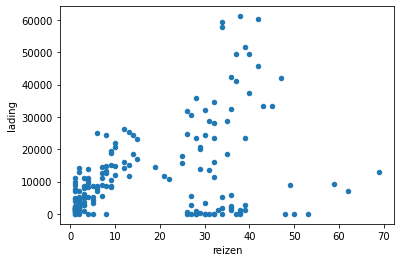

In [237]:
processed_gdf.plot.scatter(x='reizen', y='lading')

In [242]:
week_trip = processed_gdf.iloc[0]

In [247]:
processed_gdf

,country,place,source_country,source_city,target_country,target_city,jaar,week,v40_1_herkomst_land,v40_2_herkomst_plaats,v41_1_bestemming_land,v41_2_bestemming_plaats,lading,reizen,beladen_lvm,linestring
0,BE,ANR,NL,AMS,BE,ANR,2022,1,NL,AMS,BE,ANR,17975.0,25,34343.0,"LINESTRING (4.09117 51.97514, 4.07253 51.98162..."
1,BE,ANR,NL,AMS,BE,ANR,2022,2,NL,AMS,BE,ANR,30538.0,27,61458.0,"LINESTRING (4.09117 51.97514, 4.07253 51.98162..."
2,BE,ANR,NL,AMS,BE,ANR,2022,3,NL,AMS,BE,ANR,57917.0,34,88403.0,"LINESTRING (4.09117 51.97514, 4.07253 51.98162..."
3,BE,ANR,NL,AMS,BE,ANR,2022,4,NL,AMS,BE,ANR,49433.0,40,90655.0,"LINESTRING (4.09117 51.97514, 4.07253 51.98162..."
4,BE,ANR,NL,AMS,BE,ANR,2022,5,NL,AMS,BE,ANR,61148.0,38,97148.0,"LINESTRING (4.09117 51.97514, 4.07253 51.98162..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,DE,LUH,NL,AMS,DE,LUH,2022,35,NL,AMS,DE,LUH,2737.0,3,7720.0,"LINESTRING (4.09117 51.97514, 4.07253 51.98162..."
181,DE,LUH,NL,AMS,DE,LUH,2022,36,NL,AMS,DE,LUH,751.0,1,1736.0,"LINESTRING (4.09117 51.97514, 4.07253 51.98162..."
182,DE,LUH,NL,AMS,DE,LUH,2022,37,NL,AMS,DE,LUH,2660.0,2,4002.0,"LINESTRING (4.09117 51.97514, 4.07253 51.98162..."
183,DE,LUH,NL,AMS,DE,LUH,2022,38,NL,AMS,DE,LUH,2548.0,2,7107.0,"LINESTRING (4.09117 51.97514, 4.07253 51.98162..."
